In [1]:
#Import lib
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from my_useful_functions import calculate_performance_statistical_parity,calculate_performance_equalized_odds,calculate_performance_equal_opportunity,calculate_performance_predictive_parity,calculate_performance_predictive_equality,calculate_performance_treatment_equality
from sklearn import preprocessing

#Import models
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from AdaFair import AdaFair 
#Import ABROCA
from compute_abroca import *
import numpy as np
import sklearn.metrics as metrics 
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_student_mat(threshold):
    df = pd.read_csv('data/student_mat_new.csv')    
    protected_attribute = 'sex'
    majority_group_name = "Male"
    minority_group_name = "Female"
    class_label = 'Class'
    filename = "student-mat.abroca.pdf"    
    
    #Label class
    df['Class']=[1 if v >= threshold else 0 for v in df['G3']]
    df = df.drop(columns=['G3'])
    #Label sex
    df['sex']=["Female" if v == "F" else "Male" for v in df['sex']]
    
    #label encode
    le = preprocessing.LabelEncoder()
    for i in df.columns:
        if df[i].dtypes == 'object':
            df[i] = le.fit_transform(df[i])
    #Splitting data into train and test
    length = len(df.columns)
    X = df.iloc[:,:length-1]
    y = df.iloc[:,length-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
    
    #Get index    
    feature = X.keys().tolist()    
    sa_index = feature.index(protected_attribute)
    p_Group = 0 
    
    return X_train, X_test, y_train, y_test,sa_index, p_Group, protected_attribute, filename,majority_group_name,minority_group_name

In [3]:
def load_student_por(threshold):
    df = pd.read_csv('data/student-por.csv',sep=';')    
    protected_attribute = 'sex'
    majority_group_name = "Male"
    minority_group_name = "Female"
    class_label = 'Class'
    filename = "student-por.abroca.pdf"    
    
    #Label class
    df['Class']=[1 if v >= threshold else 0 for v in df['G3']]
    df = df.drop(columns=['G3'])
    #Label sex
    df['sex']=["Female" if v == "F" else "Male" for v in df['sex']]
    
    #label encode
    le = preprocessing.LabelEncoder()
    for i in df.columns:
        if df[i].dtypes == 'object':
            df[i] = le.fit_transform(df[i])
    #Splitting data into train and test
    length = len(df.columns)
    X = df.iloc[:,:length-1]
    y = df.iloc[:,length-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
    
    #Get index    
    feature = X.keys().tolist()    
    sa_index = feature.index(protected_attribute)
    p_Group = 0 
    
       
    
    return X_train, X_test, y_train, y_test,sa_index, p_Group, protected_attribute, filename,majority_group_name,minority_group_name

In [4]:
def run_experiment(classifier, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name):    
      
    #Run model
    if classifier == 'DT':
        model = tree.DecisionTreeClassifier(random_state=0)
    if classifier == 'NB':
        model = GaussianNB()
    if classifier == 'MLP':
        model = MLPClassifier(random_state=1, max_iter=300)
    if classifier == 'RF':
        model = RandomForestClassifier(max_depth=10, random_state=0)
    if classifier == 'SVM':
        model = svm.SVC(probability=True)
    if classifier == 'Adafair':
        model = AdaFair(n_estimators=50, saIndex=sa_index, saValue=p_Group, CSB="CSB2", c=1, use_validation=False)
    
    model.fit(X_train,y_train)
    y_predicts = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)
        
    #Export measures
    output = []    
    #Statistical parity
    results = calculate_performance_statistical_parity(X_test.values, y_test.values, y_predicts, sa_index, p_Group)
    output.append(results['accuracy'])
    output.append(results['balanced_accuracy'])
    output.append(results['fairness'])
    #Equal opportunity
    results = calculate_performance_equal_opportunity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group)
    output.append(results['fairness'])
    #Equalized odds
    results = calculate_performance_equalized_odds(X_test.values, y_test.values, y_predicts, y_pred_probs, sa_index, p_Group)
    output.append(results['fairness'])     
    #Predictive parity
    results = calculate_performance_predictive_parity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group)
    output.append(results['fairness'])    
    #Predictive equality
    results = calculate_performance_predictive_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group)
    output.append(results['fairness'])    
    #Treatment equality
    results = calculate_performance_treatment_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group)
    output.append(results['fairness'])    
    
    #make predictions
    X_test['pred_proba'] = model.predict_proba(X_test)[:,1:2]
    X_test['true_label'] = y_test
    df_test = X_test
    
    #Compute Abroca
    slice = compute_abroca(df_test, pred_col = 'pred_proba' , label_col = 'true_label', protected_attr_col = protected_attribute,
                           majority_protected_attr_val = 1, n_grid = 10000,
                           plot_slices = False, majority_group_name=majority_group_name ,minority_group_name=minority_group_name,file_name = filename)
    output.append(slice)
        
    return output
    

In [5]:
#Main function
def run_eval(dataset, min_threshold, max_threshold):
    set_models = ['DT','NB','MLP','RF','SVM','Adafair']
    results = [[[0 for col in range(9)]for row in range(len(set_models))] for x in range(max_threshold - min_threshold + 1)]
    
    if dataset == 'law':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name = load_law()
        run_experiment(X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name)                                        
    if dataset == 'pisa':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name = load_pisa()
        run_experiment(X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name)                                        
    if dataset == 'student-academics':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name = load_student_academics()
        run_experiment(X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name)                                            
    if dataset == 'student-mat':
        for threshold in range(min_threshold, max_threshold+1):
            print("Threshold:",threshold)            
            for classifier in range(len(set_models)):
                print("classifier:",set_models[classifier])
                X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name = load_student_mat(threshold)
                output = run_experiment(set_models[classifier],X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name)                                                                                                
                results[threshold-min_threshold][classifier] = output                
    if dataset == 'student-por':
        for threshold in range(min_threshold, max_threshold+1):
            print("Threshold:",threshold)            
            for classifier in range(len(set_models)):
                print("classifier:",set_models[classifier])
                X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name = load_student_por(threshold)
                output = run_experiment(set_models[classifier],X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name)                                                                                                
                results[threshold-min_threshold][classifier] = output                
    if dataset == 'xAPI-Edu':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name = load_xAPI_Edu()
        run_experiment(X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name)                                                                        
    
    #Rotate array
    results_output = [[[0 for col in range(len(set_models))]for row in range(max_threshold - min_threshold + 1)] for x in range(9)]
    for measure in range(9):
        for threshold in range(min_threshold,max_threshold+1):
            for model in range(len(set_models)):
                results_output[measure][threshold-min_threshold][model] = results[threshold-min_threshold][model][measure]                                                                                            

    return results_output

In [6]:
output_mat = run_eval('student-mat',min_threshold = 4, max_threshold = 16)

Threshold: 4
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 5
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 6
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 7
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 8
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 9
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 10
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 11
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 12
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Thresho

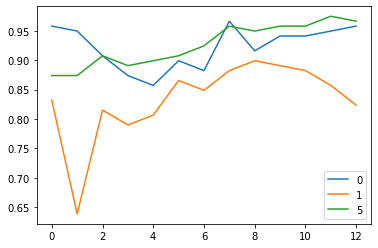

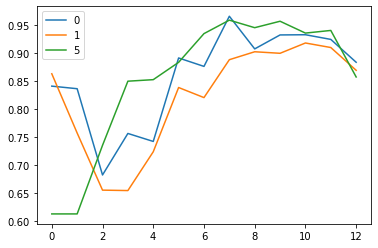

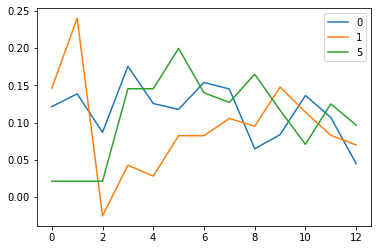

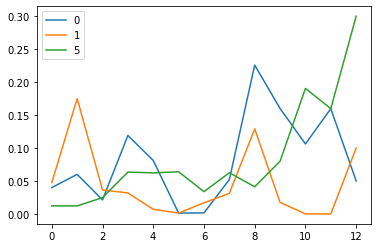

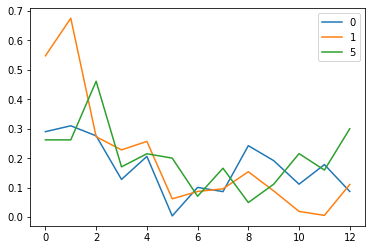

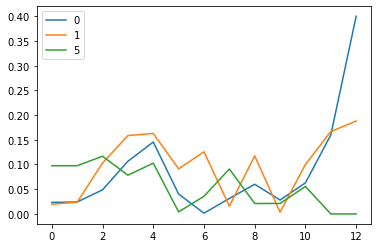

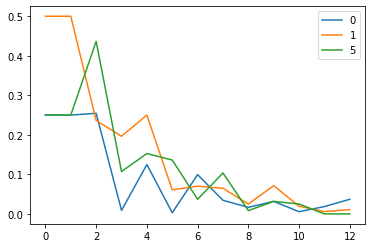

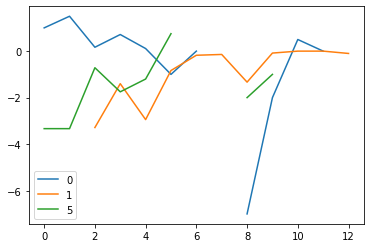

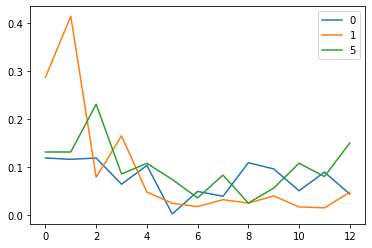

In [7]:
for measure in range(9):
    df=pd.DataFrame(output_mat[measure])
    df[[0,1,5]].plot(kind='line')

In [8]:
output_por = run_eval('student-por',min_threshold = 4, max_threshold = 16)

Threshold: 4
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 5
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 6
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 7
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 8
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 9
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 10
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 11
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Threshold: 12
classifier: DT
classifier: NB
classifier: MLP
classifier: RF
classifier: SVM
classifier: Adafair
Thresho

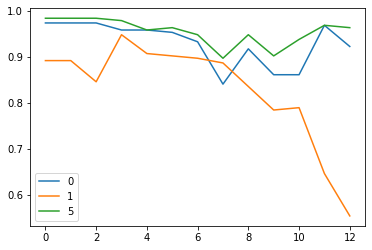

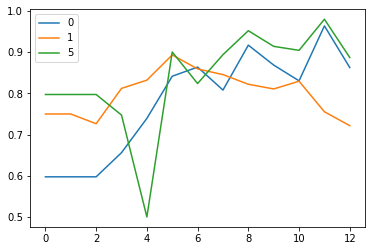

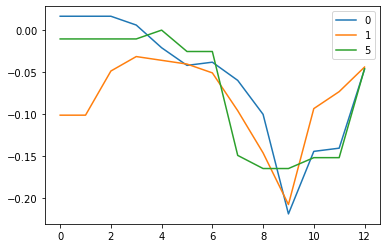

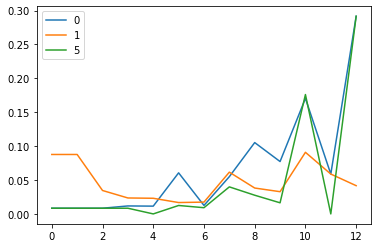

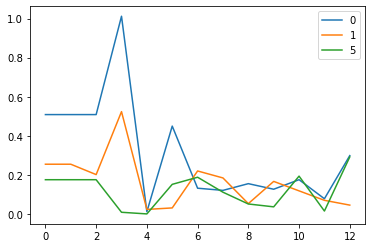

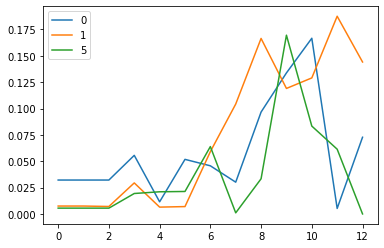

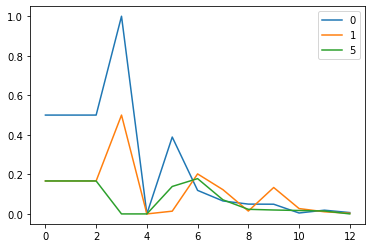

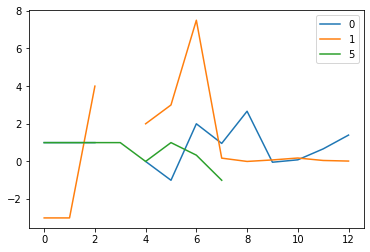

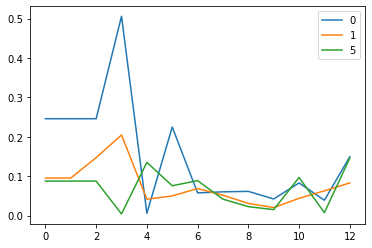

In [9]:
for measure in range(9):
    df=pd.DataFrame(output_por[measure])
    df[[0,1,5]].plot(kind='line')

In [10]:
def plot_chart(data,index,models,measures,min_threshold,max_threshold):
    for measure in range(len(measures)):
        df = pd.DataFrame(output_por[measure])
        for i in range(len(models)):
            df.rename(columns={i: models[i]})
        df = df[index]        
        plt.figure(1, figsize=(5, 4))
        ticks = [0, 2, 4, 6, 8, 10, 12]
        xticks = [4, 6, 8, 10, 12, 14, 16]
        plt.rcParams['font.size'] = '16'
        plt.rcParams["legend.loc"] = 'best'
        plt.xticks(ticks=ticks, labels=xticks)
        plt.xlabel("Grade threshold",fontweight='bold')
        plt.ylabel(measures[measure],fontweight='bold')        
        plt.plot(df.index,df)
        legend = []
        for i in index:
            legend.append(models[i])
        plt.legend(legend,fontsize=14)
        plt.grid(color='lightgrey', linestyle='--', linewidth=1)
        plt.axvline(x = 6, color = 'r', linestyle = '--',linewidth = 2 )
        filename = 'Thres.' + measures[measure] + '.pdf'
        plt.tight_layout()
        plt.savefig(filename,bbox_inches='tight')
        plt.show()

In [11]:
index=[0,1,5]
models = ['DT','NB','MLP','RF','SVM','AdaFair']
measures = ['Accuracy','Balanced accuracy','Statistical parity','Equal opportunity','Equalized odds','Predictive parity',
           'Predictive equality','Treatment equality','ABROCA']
min_threshold = 4
max_threshold = 16

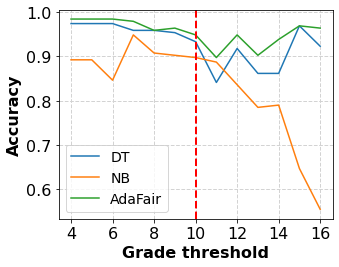

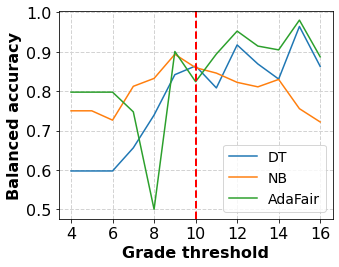

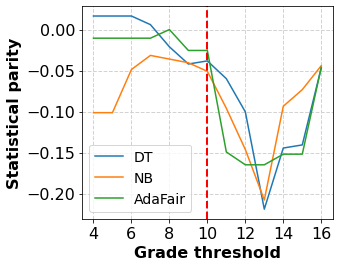

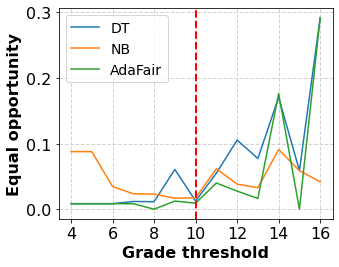

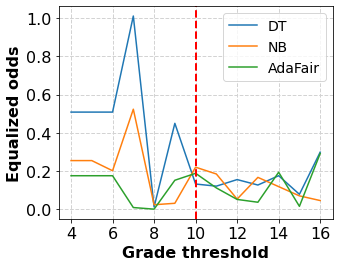

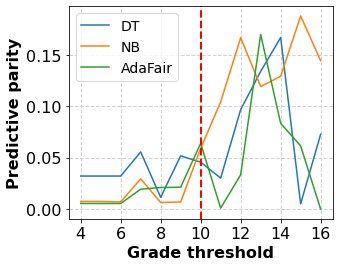

In [ ]:
plot_chart(output_por,index,models,measures,min_threshold,max_threshold)

In [ ]:
for threshold in range(4, 17):
    print('Threshold: ', threshold)
    df = pd.read_csv('data/student-por.csv',sep=';') 
    df['Class']=[1 if v >= threshold else 0 for v in df['G3']]
    df = df.drop(columns=['G3'])
    print(pd.crosstab(df['Class'], df['sex']))
